# Using Genetic Algorithms for Feature Selection

This notebook is an example implementation of a simple Genetic Algorithm applied to feature selection. It will be using the <a href="http://archive.ics.uci.edu/ml/datasets/communities+and+crime">Communities and Crime Dataset</a> from UCI Machine Learning, which has 122 attributes, aimining to use these attributes in order to predict the label (Per Capita Violent Crimes). We will use the Genetic Algorithm to select which of those 122 features are most relevant to this prediction. 

In [82]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random
import seaborn as sb

## Data Load

In [23]:
df = pd.read_csv("communities.data", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


The data file does not contain the headers, but they can be extracted from the additional file "communities.names"

In [24]:
file = open("communities.names")
header = []
for line in file:
    if "@attribute" in line: 
        header.append(line.split(" ")[1])

In [25]:
df.columns = header
df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


Let's now remove the non-predictive columns:

In [26]:
df = df.drop(["state", "county", "community", "communityname", "fold"], axis=1)
df.shape

(1994, 123)

## Data Processing

Before moving on to the GA, it's importante to make sure that any missing values have been dealt with. In this dataset, missing values are represented with a question mark. 

In [27]:
missing_value_rows = []
for i in range(df.shape[0]):
    if "?" in list(df.iloc[i].values):
        missing_value_rows.append(i)

In [28]:
print("Total rows: " + str(df.shape[0]))
print("Rows with missing values: " + str(len(missing_value_rows)))

Total rows: 1994
Rows with missing values: 1675


As seen above, most rows contain missing values, meaning we can't just get rid of all of them. Let's see what columns have the most missing values. 

In [29]:
missing_per_row = []
for column in df.columns:
    try:
        count = df[df[column] == "?"].shape[0]
    except Exception:
        count = 0
    missing_per_row.append((column, count))
sorted(missing_per_row, key=lambda tup: tup[1], reverse=True)

/usr/local/lib/python3.6/site-packages/pandas/core/ops.py:816: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


[('LemasSwornFT', 1675),
 ('LemasSwFTPerPop', 1675),
 ('LemasSwFTFieldOps', 1675),
 ('LemasSwFTFieldPerPop', 1675),
 ('LemasTotalReq', 1675),
 ('LemasTotReqPerPop', 1675),
 ('PolicReqPerOffic', 1675),
 ('PolicPerPop', 1675),
 ('RacialMatchCommPol', 1675),
 ('PctPolicWhite', 1675),
 ('PctPolicBlack', 1675),
 ('PctPolicHisp', 1675),
 ('PctPolicAsian', 1675),
 ('PctPolicMinor', 1675),
 ('OfficAssgnDrugUnits', 1675),
 ('NumKindsDrugsSeiz', 1675),
 ('PolicAveOTWorked', 1675),
 ('PolicCars', 1675),
 ('PolicOperBudg', 1675),
 ('LemasPctPolicOnPatr', 1675),
 ('LemasGangUnitDeploy', 1675),
 ('PolicBudgPerPop', 1675),
 ('OtherPerCap', 1),
 ('population', 0),
 ('householdsize', 0),
 ('racepctblack', 0),
 ('racePctWhite', 0),
 ('racePctAsian', 0),
 ('racePctHisp', 0),
 ('agePct12t21', 0),
 ('agePct12t29', 0),
 ('agePct16t24', 0),
 ('agePct65up', 0),
 ('numbUrban', 0),
 ('pctUrban', 0),
 ('medIncome', 0),
 ('pctWWage', 0),
 ('pctWFarmSelf', 0),
 ('pctWInvInc', 0),
 ('pctWSocSec', 0),
 ('pctWPubAsst

Seeing that most columns have no missing values and some columns have almost all missing values, it's best to just disregard such rows altogether and continue with the experiment. We will also drop the row with missing "OtherPerCap" information, but keep the column. 

In [30]:
df = df[df["OtherPerCap"] != "?"]
columns_to_drop = [column for column, count in missing_per_row if count == 1675]
df = df.drop(columns_to_drop, axis=1)
df.shape

(1993, 101)

We're left with 1993 rows, 100 features and 1 label.

## Genetic Algorithm

The idea of the GA is simple: we'll build a binary array of 122 positions, one for each feature. Each bit will indicate if the corresponding feature should be used or not.
  * **arr[i] == 0**: Leave out feature i
  * **arr[i] == 1**: Include feature i

We will create an initial population of N arrays, each with a random number of 0s and 1s, and we'll use evolution to find out what features bring about the best resuts.

### Fitness and Comparision

We will compare individuals in our GA through a measure of fitness based on how well scikit-learn's standard RandomForestRegressor performs when trained using that specific individual's feature selection. We will measure the regressor's performance using the root mean squared error, and define fitness as 100 / that error in order to make sure fitness values are large and that better individuals have higher feature values.

First of all, we need to establish training and test sets.

In [31]:
X = df.drop("ViolentCrimesPerPop", axis=1)
y = df["ViolentCrimesPerPop"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Now, we can build our fitness function:

In [32]:
def get_fitness(individual):
    rg = RandomForestRegressor(random_state=42)
    columns = [column for (column, binary_value) in zip(X_train.columns, individual) if binary_value]
    training_set = X_train[columns]
    test_set = X_test[columns]
    rg.fit(training_set.as_matrix(), y_train.values)
    preds = rg.predict(test_set.as_matrix())
    return 100 / np.sqrt(mean_squared_error(y_test.values, preds))

And let's take down some baselines. The first, the fitness the model gets using all features:

In [33]:
individual = [1] * 100
get_fitness(individual)

685.518493323671

Now, let's get the score of a random feature selection:

In [34]:
random_individual = [random.randint(0, 1) for i in range(100)]
get_fitness(random_individual)

667.2502967460375

Interesting! The random individual and the full features have very similar fitness. Let's see how much better our GA can get. 

The population will be represented as a list of 2-dimensional tuples, their first attribute being the individual itself (the binary array) and the second the individual's fitness. Let's build a function that, given a number of individuals, returns their population and fitness array sorted in descending order.

In [35]:
def get_population_fitness(population):
    return sorted([(individual, get_fitness(individual)) for individual in population], key=lambda tup: tup[1], reverse=True)

### Genetic Operators

Each iteration, we'll have a population of 20 individuals, based on which the next generation will be formed through the genetic operators as follows:
  * **Elitism:** The fittest candidate will continue on to the next generation
  * **Randomness**: One candidate will be selected completely randomly
  * **Tournaments**: There will be 9 tournaments of 5 randomly selected individuals. In each tournament, two individuals will be chosen (with likelihood of being choosen proportionate to their fitness) for **crossover**. The crossover will split them at a random spot and combine them.
  * **Mutation**: Finally, once the new population is formed, each individual will have a very small chance (1 in a thousand) of suffering mutation (having one random bit flipped). 

In [88]:
def crossover(individual_a, individual_b):
    crossing_point = random.randint(0, 99)
    offspring_a = individual_a[0:crossing_point] + individual_b[crossing_point:100]
    offspring_b = individual_b[0:crossing_point] + individual_a[crossing_point:100]
    return offspring_a, offspring_b

def tournament(current_population):
    index = sorted(random.sample(range(0, 20), 5))
    tournament_members  = [current_population[i] for i in index]
    total_fitness = sum([individual[1] for individual in tournament_members])
    probabilities = [individual[1] / total_fitness for individual in tournament_members]
    index_a, index_b = np.random.choice(5, size=2, p=probabilities)
    return crossover(tournament_members[index_a][0], tournament_members[index_b][0])

def mutation(individual):
    mutation_point = random.randint(0, 99)
    if(individual[mutation_point]):
        individual[mutation_point] = 0
    else:
        individual[mutation_point] = 1

def build_next_generation(current_population, mutation_rate):
    next_generation = []
    next_generation.append(current_population[0][0]) # elitism
    next_generation.append(current_population[random.randint(1,19)][0]) # randomness
    
    for i in range(9): # tournaments
        offspring_a, offspring_b = tournament(current_population)
        next_generation.append(offspring_a)
        next_generation.append(offspring_b)
    
    for individual in next_generation: # mutation
        if(random.randint(1,mutation_rate) == 1):
            mutation(individual)
    return next_generation
    
    

### Running the GA

First, let's create a function that runs the GA given an initial population and a number of generations

In [90]:
def run_ga(current_population, num_of_generations, mutation_rate=1000):
    fittest_individuals = []
    for i in range(num_of_generations):
        current_population = get_population_fitness(current_population) # get pop fitness
        fittest_individuals.append(current_population[0]) # record fittest individual (for graphing and analysis)
        current_population = build_next_generation(current_population, mutation_rate) # make new population
    return fittest_individuals
        

Now, let's generate an initial random population and make an initial run with 100 generations and see what results we get

In [74]:
initial_population = [[random.randint(0, 1) for i in range(100)] for i in range(20)]

In [75]:
fittest = run_ga(initial_population, 100)

/usr/local/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


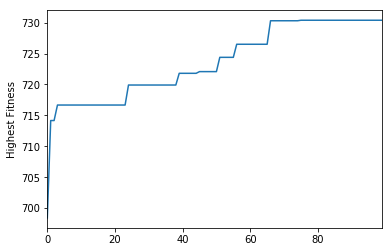

In [84]:
%matplotlib inline
fitness = [ind[1] for ind in fittest]
sb.tsplot(fitness, time=range(100), value="Highest Fitness")

Good! The GA seems to be working, as can be noticed by the clear increasing trend shown by the graph. Still, the stairs-resembling image shows that the maximum fitness often gets stuck in plateaus before moving upwards. This may mean we're not getting enough genetic diversity. Let's try to repair this by increasing mutation rates.

In [92]:
mutation_fittest = run_ga(initial_population, 100, mutation_rate=100)

/usr/local/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


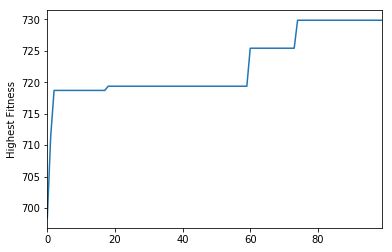

In [93]:
mutation_fitness = [ind[1] for ind in mutation_fittest]
sb.tsplot(mutation_fitness, time=range(100), value="Highest Fitness")

In [97]:
print("Top fitness without increased mutation: " + str(fitness[-1]))
print("Top fitness with increased mutation: " + str(mutation_fitness[-1]))

Top fitness without increased mutation: 730.3922802612883
Top fitness with increased mutation: 729.8626864262142


As we can see, raising the mutation probability ended up making even larger plateaus, and the final fitness highscore was slighly worse. Let's see what happens if we make mutations even more common. 

In [98]:
high_mutation_fittest = run_ga(initial_population, 100, mutation_rate=5) # one in five will suffer mutation!

/usr/local/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


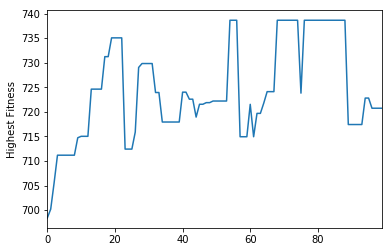

In [99]:
high_mutation_fitness = [ind[1] for ind in high_mutation_fittest]
sb.tsplot(high_mutation_fitness, time=range(100), value="Highest Fitness")

In [100]:
print("Top fitness without increased mutation: " + str(fitness[-1]))
print("Top fitness with increased mutation: " + str(mutation_fitness[-1]))
print("Top fitness with extreme mutation: " + str(max(high_mutation_fitness)))

Top fitness without increased mutation: 730.3922802612883
Top fitness with increased mutation: 729.8626864262142
Top fitness with extreme mutation: 738.6455870342481


Wow! Clearly making mutation so common made the algorithm have a lot more ups and downs, but it did at some point beat the best solution found by the last two experiment. It's also interesting to see that very significant drop around generation 90. Knowing that we have elitism in place, the only thing that could have caused that gigantic drop was a mutation, meaning that a single bit (corresponding to a single feature) change was responsible for that. This feature must be very significant. 
<br> Unfortunately, since we only recorded the top performers and not the entire populations, we have no guarantee that we'll be able to find which bit caused the drop (the drop caused by the bit flip might have so big that another individual ended up becoming the top performer).

## Analyzing Results

Let's now see which features our top performer chose!

In [114]:
for item in high_mutation_fittest[:-1]:
    if item[1] == max(high_mutation_fitness):
        top_performer = item
        break

In [116]:
print("Total features included: " + str(top_performer[0].count(1)))

Total features included: 50


In [119]:
included_columns = [column for (column, binary_value) in zip(X.columns, top_performer[0]) if binary_value]
excluded_columns = [column for (column, binary_value) in zip(X.columns, top_performer[0]) if not binary_value]

In [120]:
included_columns

['racePctWhite',
 'racePctAsian',
 'racePctHisp',
 'agePct12t21',
 'agePct12t29',
 'agePct16t24',
 'numbUrban',
 'pctUrban',
 'perCapInc',
 'whitePerCap',
 'OtherPerCap',
 'NumUnderPov',
 'PctPopUnderPov',
 'PctLess9thGrade',
 'PctNotHSGrad',
 'PctOccupManu',
 'PctOccupMgmtProf',
 'PersPerFam',
 'PctKids2Par',
 'PctWorkMomYoungKids',
 'PctWorkMom',
 'NumIlleg',
 'NumImmig',
 'PctImmigRec8',
 'PctRecentImmig',
 'PctRecImmig5',
 'PctRecImmig10',
 'PctNotSpeakEnglWell',
 'PctLargHouseFam',
 'PctLargHouseOccup',
 'PersPerOccupHous',
 'PersPerOwnOccHous',
 'PersPerRentOccHous',
 'PctHousLess3BR',
 'MedNumBR',
 'HousVacant',
 'PctHousOccup',
 'PctVacantBoarded',
 'MedYrHousBuilt',
 'PctWOFullPlumb',
 'OwnOccLowQuart',
 'OwnOccMedVal',
 'RentHighQ',
 'MedOwnCostPctInc',
 'NumInShelters',
 'NumStreet',
 'PctSameHouse85',
 'PctSameState85',
 'PctUsePubTrans',
 'LemasPctOfficDrugUn']

In [121]:
excluded_columns

['population',
 'householdsize',
 'racepctblack',
 'agePct65up',
 'medIncome',
 'pctWWage',
 'pctWFarmSelf',
 'pctWInvInc',
 'pctWSocSec',
 'pctWPubAsst',
 'pctWRetire',
 'medFamInc',
 'blackPerCap',
 'indianPerCap',
 'AsianPerCap',
 'HispPerCap',
 'PctBSorMore',
 'PctUnemployed',
 'PctEmploy',
 'PctEmplManu',
 'PctEmplProfServ',
 'MalePctDivorce',
 'MalePctNevMarr',
 'FemalePctDiv',
 'TotalPctDiv',
 'PctFam2Par',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'PctIlleg',
 'PctImmigRecent',
 'PctImmigRec5',
 'PctImmigRec10',
 'PctRecImmig8',
 'PctSpeakEnglOnly',
 'PctPersOwnOccup',
 'PctPersDenseHous',
 'PctHousOwnOcc',
 'PctVacMore6Mos',
 'PctHousNoPhone',
 'OwnOccHiQuart',
 'RentLowQ',
 'RentMedian',
 'MedRent',
 'MedRentPctHousInc',
 'MedOwnCostPctIncNoMtg',
 'PctForeignBorn',
 'PctBornSameState',
 'PctSameCity85',
 'LandArea',
 'PopDens']